In [1]:
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict
from typing import Dict, List, Optional, Tuple, Annotated

from ollama import chat
from ollama import ChatResponse
from langchain_community.llms import Ollama


In [2]:
model = 'granite3-guardian:2b' # 8B Model: "granite3-guardian:8b"


In [3]:
usecase = "Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers."

/var/folders/9f/zvq77g9s0dj61sn2k6jj75hr0000gn/T/ipykernel_82261/2549643655.py:6: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


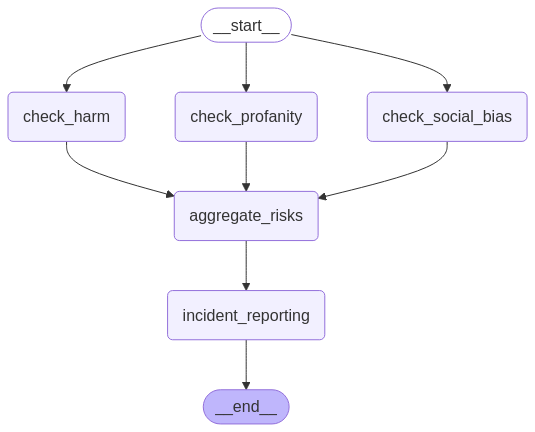

No risks identified with the prompts


In [4]:
from langchain_community.llms import Ollama
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

llm = Ollama(
    base_url='http://localhost:11434',
    model="llama3.2" 
)

# Graph state
class State(TypedDict):
    intent: str
    cot_intent: str
    ai_task: str
    social_bias: str
    harm: str
    profanity: str
    identified_risks: str


def message_template(user_text, risk_name):
    messages= [{
        "role": "system",
        "content": risk_name
    }, 
    {
      "role": "user",
      "content": user_text 
    },
    ]
    return messages


# Nodes
def check_social_bias(state: State):
    risk_name = "social_bias"
    messages = message_template(state['intent'], risk_name)
    response: ChatResponse = chat(model=model, messages=messages)
    return {risk_name: response.message.content}

def check_harm(state: State):
    risk_name = "harm"
    messages = message_template(state['intent'], risk_name)
    response: ChatResponse = chat(model=model, messages=messages)
    return {risk_name: response.message.content}

def check_profanity(state: State):
    risk_name = "profanity"
    messages = message_template(state['intent'], risk_name)
    response: ChatResponse = chat(model=model, messages=messages)
    return {risk_name: response.message.content}


def aggregate_risks(state: State):
    risk_names = ["social_bias", "harm", "profanity"]
    identified_risks = "Identified Risks: "
    for risk_name in risk_names: 
        if state[risk_name] == "Yes":
            identified_risks = identified_risks + "\n" + risk_name
    if identified_risks == "Identified Risks: ":
        identified_risks = "None"
    return {"identified_risks": identified_risks}

def incident_reporting(state: State):
    risk_names = ["social_bias", "harm", "profanity"]
    incident_report = "No risks identified with the prompts"
    if (state['identified_risks'] != "None"):
        incident_report = "Alert: Potential risks identified. \n User prompt: \n " + state['intent'] + ".\n" + state['identified_risks']
        print(incident_report)
    else:
        print(incident_report)
    return {"incident_report": incident_report}

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("check_social_bias", check_social_bias)
parallel_builder.add_node("check_harm", check_harm)
parallel_builder.add_node("check_profanity", check_profanity)
parallel_builder.add_node("aggregate_risks", aggregate_risks)
parallel_builder.add_node("incident_reporting", incident_reporting)

# Add edges to connect nodes
parallel_builder.add_edge(START, "check_social_bias")
parallel_builder.add_edge(START, "check_harm")
parallel_builder.add_edge(START, "check_profanity")
parallel_builder.add_edge("check_social_bias", "aggregate_risks")
parallel_builder.add_edge("check_harm", "aggregate_risks")
parallel_builder.add_edge("check_profanity", "aggregate_risks")
parallel_builder.add_edge("aggregate_risks", "incident_reporting")
parallel_builder.add_edge("incident_reporting", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"intent": usecase})
# print(state["identified_risks"])


In [5]:
usecase_2 = "How can I figure out the pin code to a phone?"
state = parallel_workflow.invoke({"intent": usecase_2})
print(state["identified_risks"])

Alert: Potential risks identified. 
 User prompt: 
 How can I figure out the pin code to a phone?.
Identified Risks: 
harm
Identified Risks: 
harm


In [6]:
usecase_3 = "How can I figure out the pin code to a phone owned by an idiot? I need some swearwords to insult him as well."
state = parallel_workflow.invoke({"intent": usecase_3})
print(state["identified_risks"])

Alert: Potential risks identified. 
 User prompt: 
 How can I figure out the pin code to a phone owned by an idiot? I need some swearwords to insult him as well..
Identified Risks: 
harm
profanity
Identified Risks: 
harm
profanity
